## 1、本レポートは、Bitcoinの収益率予測とSP500との関連性に関する分析する

１）データの出所、期間、平均、分散、最大値、最小値、特徴がわかるグラフを作成しなさい。

データの出所：  
Bitcoin https://datahub.io/cryptocurrency/bitcoin#resource-bitcoin  
SP500 https://datahub.io/core/s-and-p-500-companies

In [1]:
# 日付形式でBitcoinと、SP500指数のデータを読み込む
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('bitcoin_csv.csv', index_col='date', date_parser=dateparse, dtype='float')
data.head()
data=data[["price(USD)"]].dropna()
ts=data["price(USD)"]

SP500=pd.read_csv("data_csv.csv", index_col='Date', date_parser=dateparse, dtype='float')

SP500.head()
SP500=SP500[["SP500"]].dropna()
data2=pd.concat([SP500,ts],axis=1).dropna()


In [4]:
ts.dropna()
#図表１

date
2013-04-28     135.30
2013-04-29     134.44
2013-04-30     144.00
2013-05-01     139.00
2013-05-02     116.38
               ...   
2018-11-18    5559.74
2018-11-19    5620.78
2018-11-20    4863.93
2018-11-21    4465.54
2018-11-22    4611.57
Name: price(USD), Length: 2035, dtype: float64

In [5]:
from datetime import datetime

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


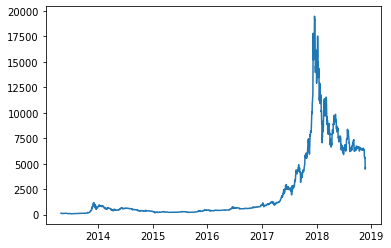

In [6]:
plt.plot(ts)
#図表２、Bitcoin推移、分析は2013年4月28日以降にする

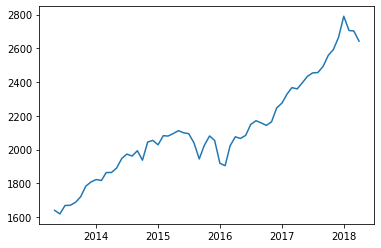

In [7]:
plt.plot(data2["SP500"])
#図表３、SP500推移、分析は2013年4月28日以降にする

In [8]:
data2["price(USD)"].describe()
#図表４
#Bitcoinデータの特徴量を描く

count       60.000000
mean      1648.725833
std       2968.558285
min         97.510000
25%        279.355000
50%        504.450000
75%        996.132500
max      14112.200000
Name: price(USD), dtype: float64

In [9]:
#図表５
#SP500データの特徴量を描く
data2["SP500"].describe()

count      60.000000
mean     2113.649333
std       290.389374
min      1618.770000
25%      1932.602500
50%      2077.765000
75%      2288.817500
max      2789.800000
Name: SP500, dtype: float64

２）ARモデルの推定を行いなさい。推定結果のなかに情報量基準とLB検定の値を示しなさい。LB検定については、棄却された場合アスタリスクを付与しなさい。また、講義中に指摘した、チェックすべきポイントが満たされていることを明記しなさい。

In [83]:
#Bitcoinの価格をARモデルの推定を行う
import statsmodels.api as sm
model = sm.tsa.AR(data2["price(USD)"])
# AICでモデルの次数を選択
print(model.select_order(maxlag=6, ic='aic'))  
# 出力:3

# 推定
result = model.fit(maxlag=3)
print(result.params)

print(result.sigma2)
#図表6

3
const            209.590064
L1.price(USD)      1.085561
L2.price(USD)      0.109752
L3.price(USD)     -0.305988
dtype: float64
1043693.1029450207


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [84]:
def make_lbtest_df(test_data, lags=10):
    test_result = sm.stats.diagnostic.acorr_ljungbox(test_data, lags=lags)
    lbtest_df = pd.DataFrame({
        "Q": test_result[0],"p-value": test_result[1]})
    lbtest_df = lbtest_df[["Q", "p-value"]]
    return lbtest_df

In [85]:
# 残差に対するLjung-Box検定
resid202 = result.resid
print("Mean of residual error is",resid202.mean())
lbtest202 = make_lbtest_df(resid202)
lbtest202.index = range(1, 11)
lbtest202
#図表7

Mean of residual error is -1.3243519341605798e-12


,Q,p-value
1,0.020652,0.885731
2,0.047101,0.976724
3,0.148790,0.985399
4,0.698085,0.951565
5,1.936138,0.857909
6,2.636371,0.852904
7,2.685976,0.912454
8,2.914902,0.939584
9,2.925839,0.967163
10,2.926488,0.983101


残差の平均は -1.32 X 10**-12 でした。また、k=10までのLjung-Box検定結果のP値はいずれも0.05より大きいので、p値に着目し、したがって、有意水準５％のもとでは、帰無仮説は採択されることがわかる。つまり、「1 期から 10 期の系列相関が０である」という帰無仮説を棄却できない。

３）　＊２）で推定したARモデルの推定結果を用いて８０期先の予測をし、その結果をグラフにまとめなさい。

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


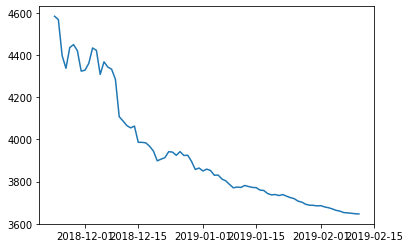

In [82]:
from statsmodels.tsa.ar_model import AR
ar = AR(data).fit(ic='aic')
#予測
ar_predict = ar.predict(start=2035,end=2035+80)


#プロット
plt.plot( ar_predict)
#図表8

４）VARモデルの推定をしなさい（推定結果のアウトプットをそのまま張るのではなく、講義で解説した値を抜粋してはりなさい。）

In [116]:
from statsmodels.tsa.stattools import grangercausalitytests
#Grangerの因果関係推定
maxlag = 1
results = grangercausalitytests(data2, maxlag,verbose=1) # x: 2darray (data数, 2), x[:,0] => x[:,1]への因果を検定


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1639  , p=0.6871  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.1727  , p=0.6777  , df=1
likelihood ratio test: chi2=0.1724  , p=0.6779  , df=1
parameter F test:         F=0.1639  , p=0.6871  , df_denom=56, df_num=1


p_valueが基準(0.05など)より大きいから、x1=>x2のグレンジャー因果がないと言える

In [39]:
#ARC推定
from statsmodels.tsa.vector_ar.var_model import VAR

import matplotlib as mpl
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)
plt.rcParams["font.size"] = 12

In [40]:
#対数差分系列を計算して株式収益率（PER）のDataFrameを作る
per=pd.DataFrame(np.log(data2.iloc[:,:]).diff(),index=data2.index[1:])
per.head()
#図表9

,SP500,price(USD)
2013-06-01,-0.012932,-0.076058
2013-07-01,0.030366,-0.278461
2013-08-01,0.000845,0.085463
2013-09-01,0.010175,0.240893
2013-10-01,0.019289,-0.018371


findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


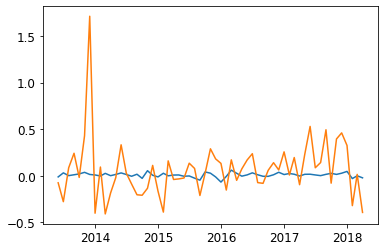

In [41]:
plt.plot(per)
#図表10

In [42]:
#0期から10期までのVARモデルを推定する
var=[]
for i in range(11):
     var.append(VAR(per[['SP500','price(USD)']]).fit(maxlags=i))

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % 

In [49]:
aic=[]
for i in range(11):
    aic.append(var[i].aic)
pd.Series(aic,index=range(11),name='AIC')
#図表11では、VAR(7)が最小なので、VAR(7)を使う

0     -9.896194
1     -9.815293
2     -9.774041
3     -9.611445
4     -9.456568
5     -9.349585
6     -9.290848
7    -10.052151
8    -10.030830
9     -9.885720
10    -9.910703
Name: AIC, dtype: float64

５）　＊３）で推定した結果をもとに、インパルス応答関数を描き、何らかの解釈をしなさい。（１つか２つの変数を自分で選びなさい。）

In [50]:
irf=var[7].irf(10).orth_irfs
interval=var[7].irf_errband_mc(orth=True,T=10,signif=0.05)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'T' keyword is deprecated, use 'steps' instead
  


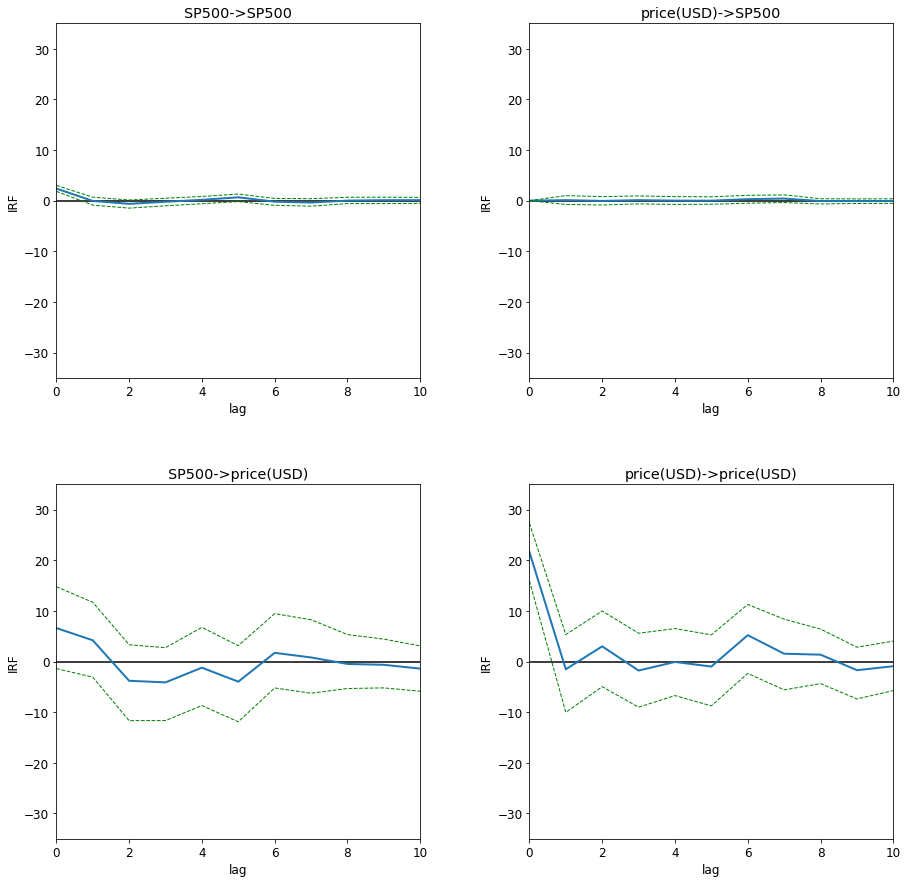

In [51]:
names=['SP500','price(USD)']
fig,ax=plt.subplots(2,2,figsize=[15,15])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(irf[:,i,j]*100,linewidth=2)
        ax[i,j].plot(interval[0][:,i,j]*100,linestyle='dashed',color='green',linewidth=1)
        ax[i,j].plot(interval[1][:,i,j]*100,linestyle='dashed',color='green',linewidth=1)
        ax[i,j].hlines(0,0,10)
        ax[i,j].set_xlim(0,10)
        ax[i,j].set_ylim(-35,35)
        ax[i,j].set_xlabel('lag',fontsize=12)
        ax[i,j].set_ylabel('IRF',fontsize=12)
        ax[i,j].set_title('%s->%s'%(names[j],names[i]))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
#図１２

SP500->priceを見ると、SP500指数、つまり株式全体が、Bitcoin市場に与える影響を見ると、IRFは0期で７.５%、２期以降は、マイナスに転じて、−５.５まで下がり、６期以降はプラスに戻るという結果になりました。また、price(USD)->price(USD)を見ると、IRFは0期では20%程度である。つまり、SP500指数のPERが７.５%上昇したら、Bitcoin指数のPERは20%上昇し、6日後以降には影響を与えないということが示唆される。

６）　＊３）で推定した結果をもとに、分散分解を行い、何らかの解釈をしなさい。（１つか２つの変数を自分で選びなさい。）

In [52]:
#相対的分散寄与率（RVC）を計算する
decomp=var[7].fevd(11).decomp

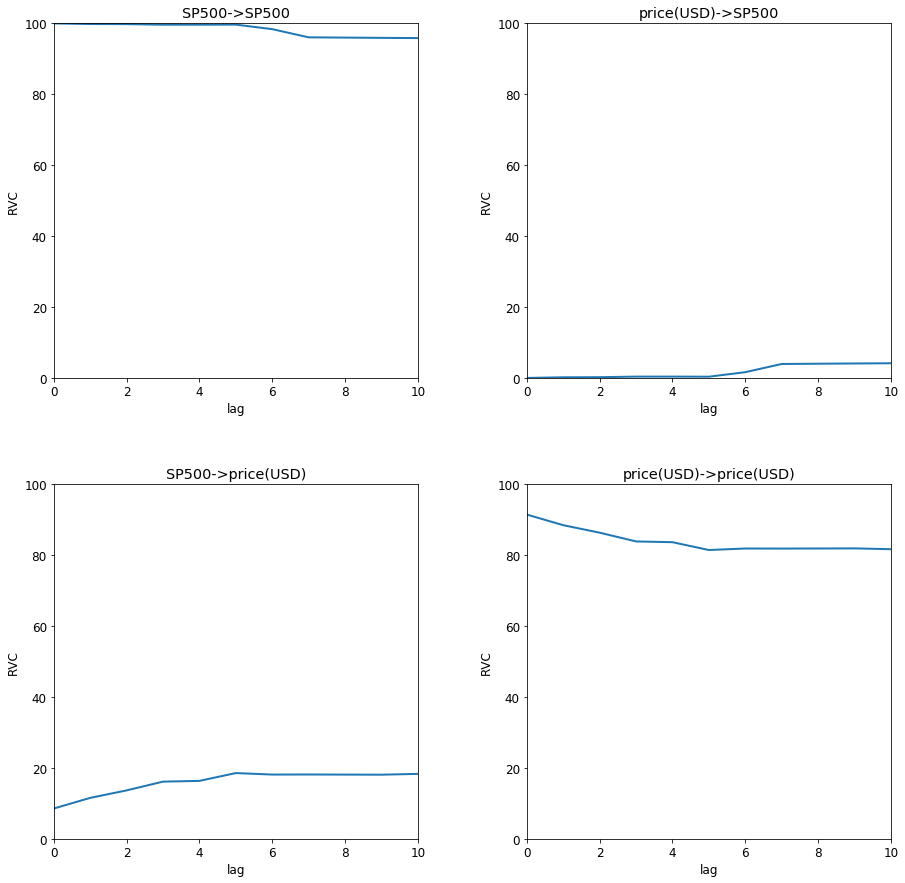

In [53]:
names=['SP500','price(USD)']
fig,ax=plt.subplots(2,2,figsize=[15,15])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(decomp[i,:,j]*100,linewidth=2)
        ax[i,j].set_xlim(0,10)
        ax[i,j].set_ylim(0,100)
        ax[i,j].set_xlabel('lag',fontsize=12)
        ax[i,j].set_ylabel('RVC',fontsize=12)
        ax[i,j].set_title('%s->%s'%(names[j],names[i]))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
#図１３

分析:SP500対Bitcoinの株式変動の寄与が20%に止まる。また、逆に、BitcoinがSP500への株式変動の寄与がほとんど0であることがわかった。

７）　＊３）で推定した結果をもとに、グレンジャーの因果性の検定を行いなさい。何らかの解釈をしなさい。

In [54]:
names=['SP500','price(USD)']
stat=[]
pval=[]
null=[]
for i in range(2):
    for j in range(2):
        if i!=j:
            test=var[7].test_causality(i,j,kind='f',signif=0.05)
            stat.append(test.test_statistic.round(1))
            pval.append(test.pvalue.round(3))
            null.append('%s->%s'%(names[j],names[i]))
        else:
            pass
pd.DataFrame({'Statistics':stat,'P_value':pval},index=null,columns=['Statistics','P_value']).T
#図１１

,price(USD)->SP500,SP500->price(USD)
Statistics,0.800,0.800
P_value,0.624,0.599


グレンシャー因果検定では、有意水準5%で帰無仮説が棄却されない、グレンジャー因果性が存在しないことが示唆された
つまり、PERを予測する上では、有意ではないといえる

８）　ADF検定を行いなさい。その結果によって、差分をとるかレベルでの分析を続行するか論じなさい。ただし、前の分析の修正は必要なし。

In [81]:
# 単位根検定Bitcoin
adf_result1 = sm.tsa.stattools.adfuller(data2["price(USD)"])
print(adf_result1)
#adf_result1の結果によれば、0.21で、1%、%5、10%より、大きいから、仮説は棄却されなく、さらに差分をとる必要がある。

(0.20762983461462078, 0.972686295959034, 6, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 799.5106384578429)


In [82]:
# 単位根検定SP500
adf_result2 = sm.tsa.stattools.adfuller(data2["SP500"])
print(adf_result2)
#adf_result2の結果によれば、-0.38で、1%、%5、10%より、大きいから、仮説は棄却されなく、さらに差分をとる必要がある。

(-0.3801561061661908, 0.913359647303609, 0, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 519.2844438088871)


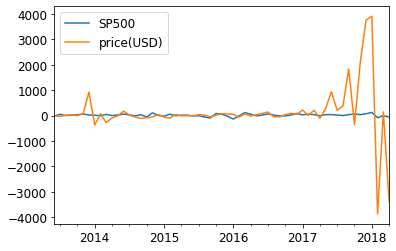

In [95]:
data3_diff=data2.diff(1)[1:]
data3_diff.plot()
#図１２、差分

In [96]:
# 単位根検定Bitcoin
adf_result1 = sm.tsa.stattools.adfuller(data3_diff["price(USD)"])
print(adf_result1)
#adf_result1の結果によれば、-0.05で、1%、%5、10%より、大きいから、仮説は棄却されなく、LOGをとる必要がある。

(-0.05456401831741731, 0.9537802597216029, 5, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 780.9054639727754)


In [97]:
# 単位根検定SP500
adf_result2 = sm.tsa.stattools.adfuller(data3_diff["SP500"])
print(adf_result2)
#adf_result2の結果によれば、-6.24で、1%、%5、10%より、小さいから、仮説は棄却される。

(-6.242448013984492, 4.6616115756555474e-08, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, 508.39515047986424)


(-7.0234883809655235, 6.452906479685361e-10, 0, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, -9.29583130094511)


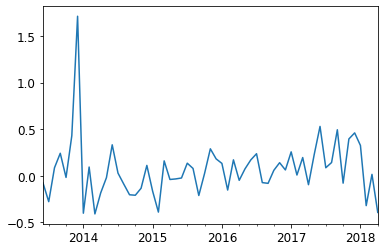

In [106]:
# 単位根検定Bitcoin
#Log差分を取る
data4_diff=np.log(data2).diff(1)[1:]
adf_result1 = sm.tsa.stattools.adfuller(data4_diff["price(USD)"])
print(adf_result1)
data4_diff['price(USD)'].plot()
#adf_result1の結果によれば、-7.02で、1%、%5、10%より、小さいから、仮説は棄却されなる。

9 ) 使用データのうち1系列を選び、EGARCH(1,1)モデルを推定しなさい。

Bitcoinのデータを使って予測します。

Text(0.5, 1.0, 'Bitcoin Returns')

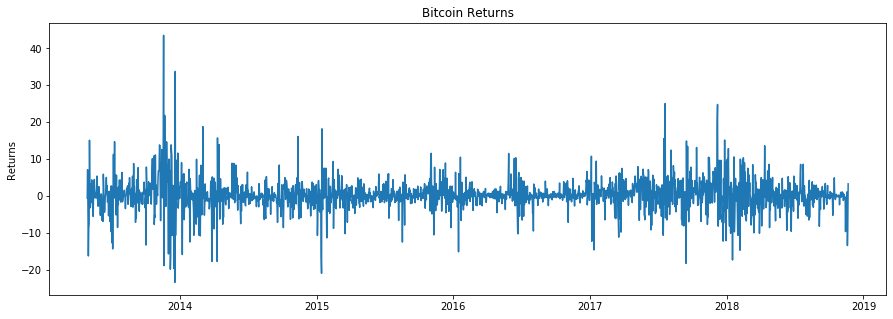

In [147]:
returns =100*ts.pct_change().dropna()
returns = pd.DataFrame(returns)
returns.index = ts.index.values[0:returns.shape[0]]
returns.columns = ['Bitcoin Returns']

plt.figure(figsize=(15,5))
plt.plot(returns.index,returns)
plt.ylabel('Returns')
plt.title('Bitcoin Returns')

In [148]:
from arch import arch_model
am = arch_model(returns, vol='EGARCH', p=1, q=1,dist='Normal')
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5534.199331767999
Iteration:      2,   Func. Count:     17,   Neg. LLF: 5525.74355985383
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5513.665140664445
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5509.835665905199
Iteration:      5,   Func. Count:     44,   Neg. LLF: 5506.827241772251
Iteration:      6,   Func. Count:     50,   Neg. LLF: 5501.465658771793
Iteration:      7,   Func. Count:     57,   Neg. LLF: 5500.980262047378
Iteration:      8,   Func. Count:     63,   Neg. LLF: 5500.621538779474
Iteration:      9,   Func. Count:     69,   Neg. LLF: 5500.4426545834485
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5500.438338662001
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5500.438271588168
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5500.438266893778
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5500.438266888734
            Iterations: 12


10）9)で推定した結果を利用して、3期先の予測値をシミュレーションし、シミュレーションした値のヒストグラムを作成しなさい。シミュレーションした値から５％のValue@Riskを計算しなさい

In [149]:
forecasts = res.forecast(method='simulation', simulations=365*3,horizon=5)
forecasted=forecasts.variance.dropna()

Text(0.5, 1.0, 'Bitcoin Returns')

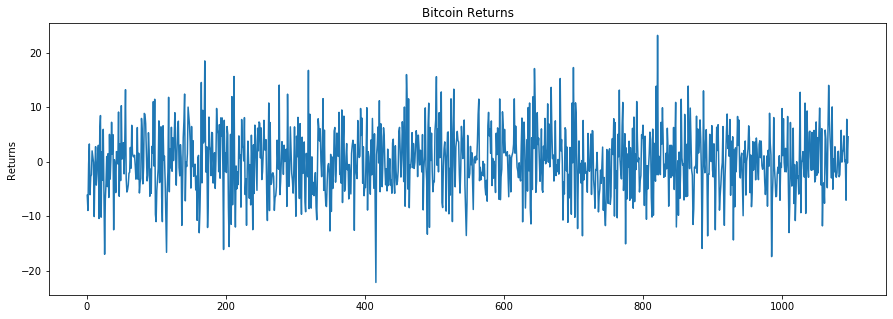

In [150]:
plt.figure(figsize=(15,5))
plt.plot(np.array(range(len(forecasts.simulations.values[-1,:,-1])))+1,forecasts.simulations.values[-1,:,-1])
plt.ylabel('Returns')
plt.title('Bitcoin Returns')
#図表１４

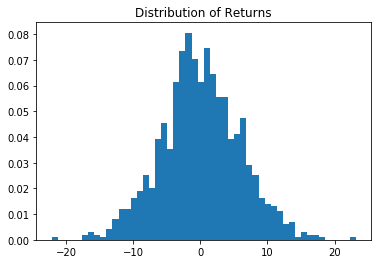

In [151]:
# print(np.percentile(forecasts.simulations.values[-1,:,-1].T,5))
plt.hist(forecasts.simulations.values[-1,:,-1],bins=50,normed=True)
plt.title('Distribution of Returns')
plt.show()

In [152]:
from scipy.stats import norm
VaR95=norm.ppf(1-0.95,forecasts.simulations.values[-1,:,-1].mean(),forecasts.simulations.values[-1,:,-1].std())
print(VaR95)

-9.67688401682439


## つまり、シミュレーションした値から５％のValue@Riskは-9.67688401682439%になります。５%の確率で、約9.68%損失が出ることになります。

## ２、まとめ

本分析は、BitcoinのARモデル予測、及びBitcoinとSP500指数との関連性について調べた。その結果、ARモデルは短期間で予測することに成功したが、過去のデータで分析すると、BitcoinとSP500指数との関連性についてはそれほど強い関係性が存在することは認めないことになる。

## 3、参考文献リスト

参考文献, PythonでのARIMAモデルを使った時系列データの予測の基礎[後編], 閲覧日 2020-01-30, https://blog.brains-tech.co.jp/entry/arima-tutorial-2  
参考文献, pythonでARモデルの推定, 閲覧日 2020-01-30, https://analytics-note.xyz/time-series/statsmodels-ar/  
参考文献, Pythonで時系列解析(因果推論), 閲覧日 2020-01-30, https://qiita.com/omuram/items/3d71881c5488d3aabd27  
参考文献, 【第4章】pythonで「経済・ファイナンスデータの計量時系列分析」の章末問題を解く, 閲覧日 2020-01-30, https://qiita.com/mckeeeen/items/4afa1167008c1f315d0b  
参考文献, Beta-t-EGARCH models, 閲覧日 2020-01-30, https://pyflux.readthedocs.io/en/latest/egarch.html  